In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn

from functools import partial
from sklearn import datasets

In [2]:
iris = datasets.load_iris(as_frame=True)

In [3]:
sepal_width = iris.data["sepal width (cm)"].values

In [4]:
def ll(data, params):
    return np.sum(scipy.stats.norm.logpdf(data, *params))

def nll(data, params):
    return -1 * ll(data, params)

In [5]:
sol = scipy.optimize.minimize(partial(nll, sepal_width), x0=[0, 1], method="SLSQP")
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 87.77614099590977
       x: [ 3.057e+00  4.344e-01]
     nit: 16
     jac: [-2.404e-02 -1.289e-02]
    nfev: 65
    njev: 16

In [19]:
# ll target for upper 99/75
conf = 0.99
cover1_up = 0.75
cover1_lo = 0.25

def calc_ll_target(conf, data, params, sided=1):
    ll_mle = ll(data, params)
    alpha_eff = 2 * (1 - conf) / sided
    print("alpha effective:", alpha_eff)
    chi2val = scipy.stats.chi2.ppf(1 - alpha_eff, df=1)
    ll_target = ll_mle - chi2val / 2
    return ll_target

ll_target = calc_ll_target(conf, sepal_width, sol.x, sided=1)
ll_target2 = calc_ll_target(conf, sepal_width, sol.x, sided=2)
ll(sepal_width, sol.x), ll_target, ll_target2

alpha effective: 0.020000000000000018
alpha effective: 0.010000000000000009


(np.float64(-87.77614099590977),
 np.float64(-90.48208821143695),
 np.float64(-91.09358929642038))

In [20]:
def ll_target_cons(data, ll_target, params):
    return ll_target - ll(data, params)


def obj_upper(coverage, params):
    return -1 * scipy.stats.norm.ppf(coverage, *params)


def obj_lower(coverage, params):
    return scipy.stats.norm.ppf(coverage, *params)


def obj_double(lower_coverage, upper_coverage, params):
    upper_quantile = scipy.stats.norm.ppf(upper_coverage, *params)
    lower_quantile = scipy.stats.norm.ppf(lower_coverage, *params)
    return lower_quantile - upper_quantile  # Minimize this <-> maximize interval width, which is upper_quantile - lower_quantile

In [21]:
tl1cons = [{"type": "eq", "fun": partial(ll_target_cons, sepal_width, ll_target)}]
tl2cons = [{"type": "eq", "fun": partial(ll_target_cons, sepal_width, ll_target2)}]

In [30]:
sol_upper = scipy.optimize.minimize(partial(obj_upper, cover1_up), x0=sol.x, method="SLSQP", constraints=tl1cons, options={"maxiter": 2500})
sol_upper, scipy.stats.norm.ppf(cover1_up, *sol_upper.x)

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: -3.447767195631491
        x: [ 3.133e+00  4.671e-01]
      nit: 24
      jac: [-1.000e+00 -6.745e-01]
     nfev: 130
     njev: 24,
 np.float64(3.447767195631491))

In [51]:
sol_lower = scipy.optimize.minimize(partial(obj_lower, cover1_lo), x0=sol.x, method="SLSQP", constraints=tl1cons, options={"maxiter": 2500})
sol_lower, scipy.stats.norm.ppf(cover1_lo, *sol_lower.x)

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: 2.666899463558954
        x: [ 2.982e+00  4.671e-01]
      nit: 7
      jac: [ 1.000e+00 -6.745e-01]
     nfev: 29
     njev: 7,
 np.float64(2.666899463558954))

In [40]:
sol_double = scipy.optimize.minimize(partial(obj_double, cover1_lo, cover1_up), x0=sol.x, constraints=tl2cons, options={"maxiter": 2500})
sol_double

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6852661351057296
       x: [ 3.057e+00  5.080e-01]
     nit: 22
     jac: [ 0.000e+00 -1.349e+00]
    nfev: 105
    njev: 22

In [50]:
# analytic solutions
n = sepal_width.size
non_centrality = np.sqrt(n) * scipy.stats.norm.ppf(cover1_up)
k = (1 / np.sqrt(n)) * scipy.stats.nct.ppf(conf, n-1, non_centrality)
sol.x[0] - k * sol.x[1], sol.x[0] + k * sol.x[1]

(np.float64(2.6660308477310295), np.float64(3.448575328466582))

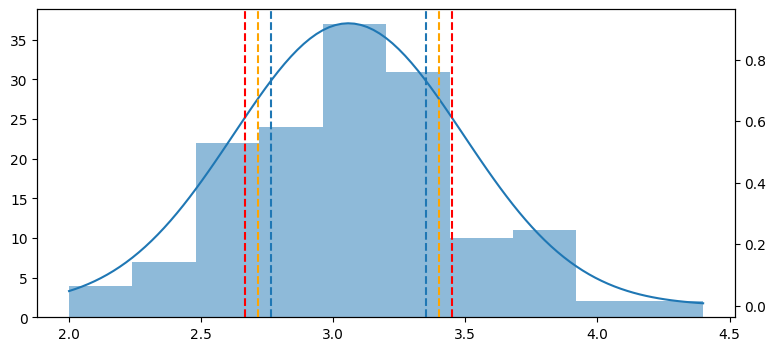

In [52]:
fig, ax1 = plt.subplots(figsize=(9,4))
ax2 = ax1.twinx()

xarr = np.linspace(sepal_width.min(), sepal_width.max(), 101)

ax1.hist(sepal_width, alpha=0.5)

ax2.plot(xarr, scipy.stats.norm.pdf(xarr, *sol.x))
ax2.axvline(scipy.stats.norm.ppf(cover1_up, *sol.x), linestyle="--")
ax2.axvline(scipy.stats.norm.ppf(cover1_lo, *sol.x), linestyle="--")

ax2.axvline(scipy.stats.norm.ppf(cover1_up, *sol_upper.x), linestyle="--", color="red")
ax2.axvline(scipy.stats.norm.ppf(cover1_lo, *sol_lower.x), linestyle="--", color="red")

ax2.axvline(scipy.stats.norm.ppf(cover1_up, *sol_double.x), linestyle="--", color="orange")
ax2.axvline(scipy.stats.norm.ppf(cover1_lo, *sol_double.x), linestyle="--", color="orange")